# <center>**Online Shoppers Purchasing Intention**</center>
***

### Kelompok LAMBA :
Abdul Ghofur <br>
Angeline Shirley<br>
Dzaky Fachrezi<br>
Iqbal Octoryaz<br>
M. Tohar Sagara<br>
Rahma Yanti<br>
Syofwan Aldia<br>
Widi Bagaskara

## **About Dataset**
***

Dataset Online Shoppers Purchasing Intention terdiri dari 18 features yang dikelompokan berdasarkan tipe data nya : <br>

| **Numerical data**     | **Categorical data**|
|----------------------- |------------- |
|Administrative | OperatingSystems|
|Administrative_Duration | Browser|
|Informational | Region|
|Informational_Duration | TrafficType|
|ProductRelated | Month|
|ProductRelated_Duration | VisitorType|
|BounceRates | Weekend |
|ExitRates | Revenue|
|PageValues |
|SpecialDay |

## **Import Libraries**
***

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

## **Read Dataset**
***

In [28]:
df = pd.read_csv('Data/online_shoppers_intention.csv')

Univariate Analysis dilakukan untuk menganalisa setiap kolom secara terpisah, melihat distribusi nilainya secara detail.

***
## **Data Pre-Processing**
***

**Separate Features base on type**

In [1]:
# pengelompokan kolom berdasarkan jenisnya

nums = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

cats = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month', 
        'VisitorType', 'Weekend']

## **1. Data Cleansing**
***

**features encoding**

In [9]:
def ordinal_encode(data, column, order):
    data = data.copy()
    data[column] = data[column].apply(lambda x: order.index(x))
    return data

def onehot_encode(data, column, prefix):
    data = data.copy()
    dummies = pd.get_dummies(data[column], prefix=prefix)
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column, axis=1)
    return data

In [10]:
# create a copy of original df
df_encode = df.copy()

#ordering the month
month_order = ["Jan","Feb", "Mar", "Apr", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# label encoding the month
df_encode = ordinal_encode(df_encode, 'Month', month_order)

# one-hot encoding the VisitorType
df_encode = onehot_encode(df_encode, 'VisitorType', 'visitor')

In [11]:
df_encode.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,visitor_New_Visitor,visitor_Other,visitor_Returning_Visitor
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,1,1,1,1,1,False,False,0,0,1
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,1,2,2,1,2,False,False,0,0,1


In [12]:
# shift column 'Revenur' to last position
last_column = df_encode.pop('Revenue')
  
# insert column using insert(position,column_name,
# first_column) function
df_encode.insert(19, 'Revenue', last_column)

df_encode.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,visitor_New_Visitor,visitor_Other,visitor_Returning_Visitor,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,1,1,1,1,1,False,0,0,1,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,1,2,2,1,2,False,0,0,1,False


<AxesSubplot:>

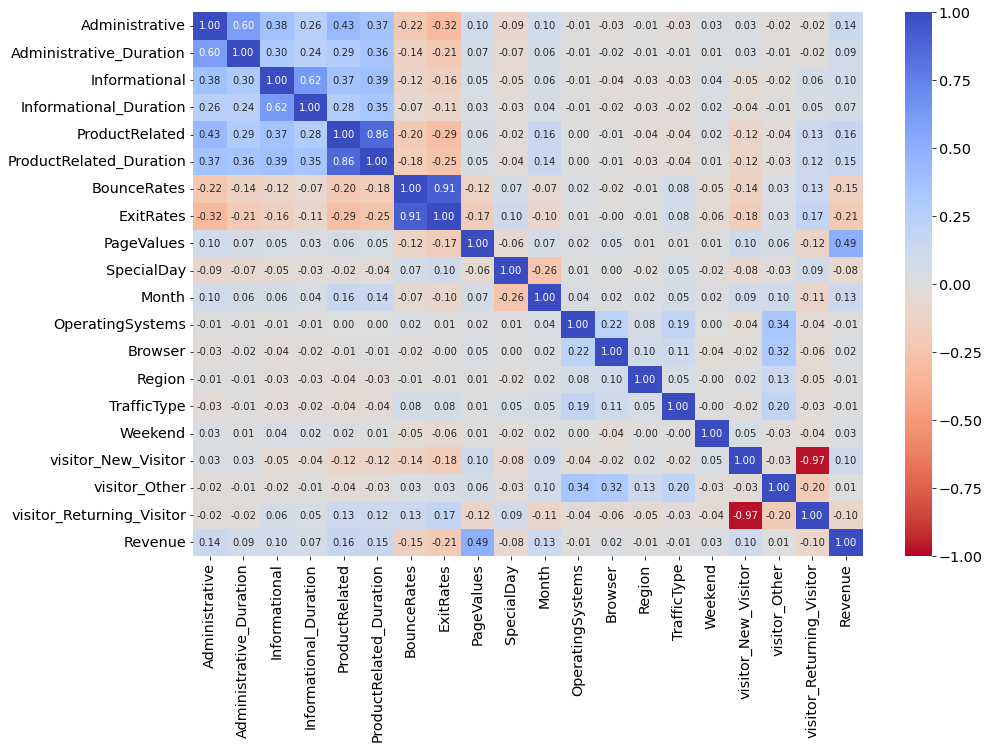

In [103]:
plt.figure(figsize=(15,10))
sns.heatmap(df_encode.corr(), cmap='coolwarm_r', annot=True, fmt='.2f',vmin=-1, vmax=1)

***
## **2. Feature Engineering**
***

**Import library**

In [31]:
# import library
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing

**Split Features and Target**

In [32]:
# split feature and target

# features
X = df_encode.drop('Revenue', axis=1)
# target
y = df_encode['Revenue'].copy()

***
### **2.A Feature selection**

Kategori features yang bisa di-drop dari hasil Univariate dan Multivariate analysis adalah sbb : <br>

1. Feature kategorikal yg hanya punya 1 atau 2 data yg dominan  --> Browser dan Region <br>
2. Feature kategorical dengan jumlah nilai unique nya banyak  --> TrafficType. Namun untuk type ini sudah dilakukan Thershold untuk mengurangi jumlah nunique- nya pada Data Cleansing<br>
3. Salah satu dari 2 feature yang berkorelasi dengan nilai > 0.7 (redundant) --> ExitRate <br>

Asumsi awal features yang berpeluang untuk di-drop adalah : **Browser, Region, ExitRate**

**Asumsi** ini akan dicoba dilakukan **validasi** dengan **metode feature selection** dibawah.

#### **2.A.1 Feature selection for Numerical data**

**REDUNDANT FEATURES**

premis : jika 2 feature berkorelasi dengan nilai > 0.7 maka feature tersebut redundant dan bisa di-drop salah satunya

In [15]:
# function to get features correlation with threshold > 0.7

def correlation(dataset, threshold):
    col_corr = [] 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.append(colname)
    return col_corr 

corr_features = correlation(df_encode[nums], 0.7)
corr_features

['ProductRelated_Duration', 'ExitRates']

***
[x] **ExitRates** berkorelasi kuat dengan **BounceRates**.--> 2 feature yg tidak mengenerate revenue <br>
[v] **ProductRelated_Duration** berkorelasi kuat dengan **ProductRelated** --> akan dilakukan feature extraction.<br>


| **Asumsi Awal**     | **Konfirmasi**|
|----------------------- |------------- |
|Browser | |
|Region  |                 |
|TrafficType | |
|ExitRates | ExitRate|

***

**CHI SQUARE**

premis : semakin rendah nilai p-value sebuah feature maka semakin penting feature tersebut.

In [33]:
#calculate F score and p value
f_p_values=chi2(X[nums],y)
f_p_values

(array([1.13396553e+03, 4.17548368e+04, 3.57981605e+02, 3.50597758e+04,
        1.93172854e+04, 8.77404339e+05, 2.96543359e+01, 2.89850721e+01,
        1.75126809e+05, 5.37970945e+01]),
 array([1.37016070e-248, 0.00000000e+000, 7.74616955e-080, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 5.16369980e-008, 7.29382084e-008,
        0.00000000e+000, 2.22301227e-013]))

In [19]:
#ordering the features
p_values=pd.Series(f_p_values[1])
p_values.index=X[nums].columns
p_values

p_values.sort_values(ascending=True)

Administrative_Duration     0.000000e+00
Informational_Duration      0.000000e+00
ProductRelated              0.000000e+00
ProductRelated_Duration     0.000000e+00
PageValues                  0.000000e+00
Administrative             1.370161e-248
Informational               7.746170e-80
SpecialDay                  2.223012e-13
BounceRates                 5.163700e-08
ExitRates                   7.293821e-08
dtype: float64

***
2 features dengan nilai p value tertinggi <br>
[x] **BounceRatse & ExitRates** --> Feature yang berkorelasi kuat dengan ExitRates. ExitRates yang akan di-drop.

| **Asumsi Awal**     | **Konfirmasi**|
|----------------------- |------------- |
|Browser | |
|Region  |                 |
|TrafficType | |
|ExitRates | ExitRate|


***

**MUTUAL INFORMATION**

premis : semakin tingggi nilai mutual info maka semakin penting feature tersebut

In [20]:
# determine the mutual information
mutual_info = mutual_info_classif(X[nums], y)
mutual_info

array([0.011299  , 0.0174722 , 0.00850913, 0.00506542, 0.0233267 ,
       0.03251941, 0.02197948, 0.0429138 , 0.16682847, 0.00125975])

In [22]:
# ordering the features
mutual_info = pd.Series(mutual_info)
mutual_info.index = X[nums].columns
mutual_info.sort_values(ascending=False)

PageValues                 0.166828
ExitRates                  0.042914
ProductRelated_Duration    0.032519
ProductRelated             0.023327
BounceRates                0.021979
Administrative_Duration    0.017472
Administrative             0.011299
Informational              0.008509
Informational_Duration     0.005065
SpecialDay                 0.001260
dtype: float64

***
feature dengan nilai mutual_info terendah <br>
[x] **SpecialDay** --> Feature yang mempunyai nilai korelasi terhadap target sebesar -0.08

| **Asumsi Awal**     | **Konfirmasi**|
|----------------------- |------------- |
|Browser | |
|Region  |        |
|TrafficType | |
|ExitRates | ExitRate|
| | SpecialDay|

***

<AxesSubplot:>

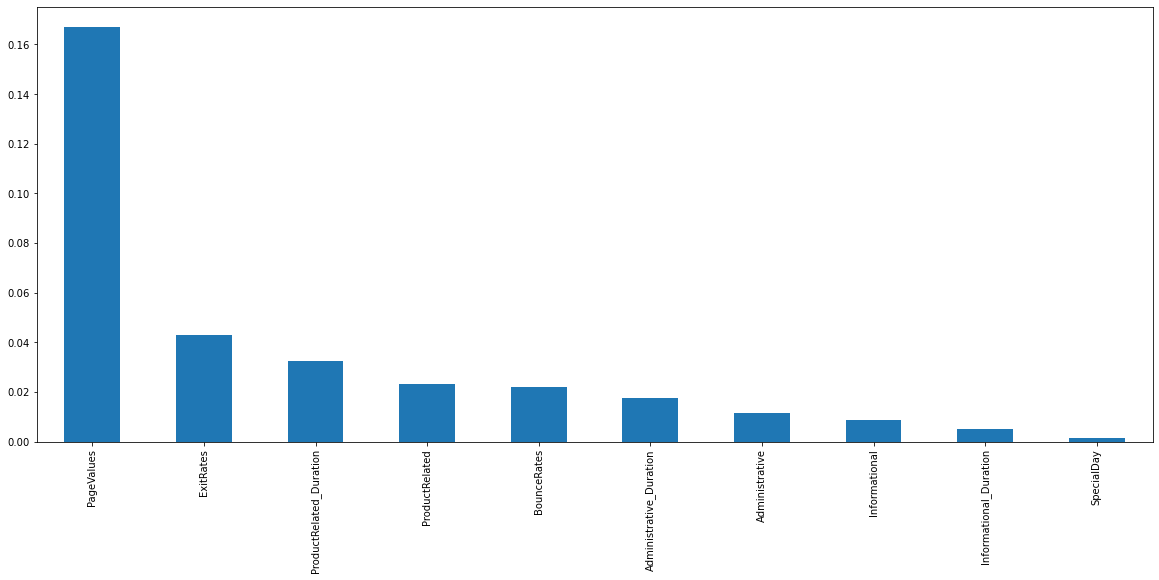

In [23]:
# plotting
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

**KESIMPULAN**

Dari hasil asumsi awal dan hasil metode **Chi Square** dan **Mutual Info** terdapat 1 feature yang mempunyai Chi-Square yang sangat besar dan juga mempunyai korelasi > 0.7 dengan feature lain yaitu : **ExitRates**.

Sampai tahap ini maka diputuskan akan melakuka drop terhadap fitur **numerik** : **ExitRates**


#### **2.A.1 Feature selection for Categoricals data**

***
### **2.B Feature extraction**

#### **2.B.1 Total Visit**

Total jumlah page yang dikunjungi per masing-masing sesi

In [37]:
# Total durasi kunjungan per masing-masing sesi
df_ex = df_encode.copy()
df_ex['totalPage_visit'] = df_ex['Administrative'] + df_ex['Informational'] + df_ex ['ProductRelated']

#atau 

df_ex['adm'] = df_ex['Administrative'] / df_ex['Administrative_Duration']
df_ex['info'] = df_ex['Informational'] / df_ex['Informational_Duration']
df_ex['product'] = df_ex['ProductRelated'] / df_ex['ProductRelated_Duration']


In [38]:
df_ex.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType,Weekend,visitor_New_Visitor,visitor_Other,visitor_Returning_Visitor,Revenue,totalPage_visit,adm,info,product
1054,4,315.0,0,0.0,8,465.833333,0.0,0.024242,0.0,0.0,...,3,True,0,0,1,False,12,0.012698,NaN,0.017174
3596,4,738.0,0,0.0,21,664.333333,0.0,0.015278,0.0,0.0,...,2,True,0,0,1,False,25,0.005420,NaN,0.031611
10818,0,0.0,0,0.0,51,1655.358333,0.0,0.013072,0.0,0.0,...,2,True,0,0,1,False,51,NaN,NaN,0.030809
11326,0,0.0,0,0.0,2,26.500000,0.0,0.050000,0.0,0.0,...,1,True,0,0,1,False,2,NaN,NaN,0.075472
130,0,0.0,0,0.0,2,222.000000,0.0,0.100000,0.0,0.0,...,2,True,0,0,1,False,2,NaN,NaN,0.009009


#### **2.B.2 Total Duration**

Total durasi kunjungan per masing-masing sesi

In [39]:
# Total durasi kunjungan per masing-masing sesi
df_ex['total_duration'] = df_ex['Administrative_Duration'] + df_ex['Informational_Duration'] + df_ex ['ProductRelated_Duration']

In [40]:
df_ex.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Weekend,visitor_New_Visitor,visitor_Other,visitor_Returning_Visitor,Revenue,totalPage_visit,adm,info,product,total_duration
8635,0,0.0,0,0.0,44,784.883333,0.000000,0.004762,360.953384,0.0,...,False,0,1,0,True,44,NaN,NaN,0.056059,784.883333
3956,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,False,0,0,1,False,1,NaN,NaN,inf,0.000000
6404,0,0.0,0,0.0,3,60.400000,0.000000,0.066667,0.000000,0.0,...,False,0,0,1,False,3,NaN,NaN,0.049669,60.400000
10076,4,59.5,2,662.0,31,1586.154762,0.016667,0.037334,0.000000,0.0,...,False,0,0,1,False,37,0.067227,0.003021,0.019544,2307.654762
716,2,306.0,0,0.0,14,964.500000,0.000000,0.030952,0.000000,0.0,...,False,0,0,1,False,16,0.006536,NaN,0.014515,1270.500000


#### **2.B.3 Rasio (Page/Duration)**

In [41]:
df_ex['adm'] = df_ex['Administrative'] / df_ex['Administrative_Duration']
df_ex['info'] = df_ex['Informational'] / df_ex['Informational_Duration']
df_ex['product'] = df_ex['ProductRelated'] / df_ex['ProductRelated_Duration']

df_ex.sample(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Weekend,visitor_New_Visitor,visitor_Other,visitor_Returning_Visitor,Revenue,totalPage_visit,adm,info,product,total_duration
12238,1,0.0,1,46.5,22,671.866667,0.017391,0.02058,0.0,0.0,...,False,0,0,1,False,24,inf,0.021505,0.032745,718.366667
7543,2,126.0,0,0.0,2,14.350000,0.000000,0.05000,0.0,0.0,...,True,1,0,0,False,4,0.015873,NaN,0.139373,140.350000


***
### **2.C Feature tambahan**

1. Customer ID - Data memiliki unique value dan bisa diketahui dan dilakukan tracing perilaku konsumen dan transaksi berulang
2. Returning Page - Untuk dapat mengetahui page-page mana yang dibuka berulang kali, hal ini menandakan ketertarikan konsumen pada page tersebut
3. Seller Reputation - Asumsinya reputasi seller akan berpengaruh pada minat beli dan keputusan beli
4. Satisfaction Score - untuk mengetahui kepuasan terhadap transaksi di web dan kaitannya apakah dapat meningkatkan revenue
5. Product in Basket - fitur ini dapat mengetahui user yang memiliki minat beli namun belum melakukan transaksi.
6. Gender - Fitur ini bertujuan untuk mengetahui sebaran revenue per masing-masing Jenis kelamin user